In [1]:
import os, sys
print(sys.version)
print("--"* 60)
# print("Python executable:", sys.executable)
# print("--"* 60)
# print("PATH:", os.environ["PATH"])

3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
------------------------------------------------------------------------------------------------------------------------


In [2]:
os.environ["PATH"] = ("/home/alka23224/miniconda3/envs/implicit_sindy/bin:" + os.environ["PATH"])

In [3]:
# -------------------------------
# Current working directory
# -------------------------------
# print(os.listdir())
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")


Current working directory: /home/alka23224/CAR-T-Cell_Problem_V1


In [4]:
# -------------------------------
plot_dir = os.path.join(current_dir, "Plots 4")
os.makedirs(plot_dir, exist_ok=True) 

In [5]:
# -----------------------------
# Import Necessary Libraries
# -----------------------------
import numpy as np
import pandas as pd
import pysindy as ps
import sympy as sp
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
import plotly.graph_objects as go
from matplotlib.ticker import LogFormatterMathtext
from sympy import symbols, Eq, solve, Matrix, N, simplify, nsimplify
from IPython.display import display
from IPython.display import Image
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from pysindy.differentiation import SmoothedFiniteDifference
from pysindy.feature_library import CustomLibrary
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm
from sympy import lambdify

In [6]:
# Import helper
from plot_utils import set_plot_style, set_spines_black
from symbolic_parser import build_expr_map, build_symbolic_rhs
from network_utils import draw_network
from steady_states import*
from combined_library import get_library
from sindy_utils import run_sindy_grid_search
set_plot_style()

In [7]:
# ----------------------------------------
#  Load CSV  (Combined data frame)
# ----------------------------------------
df = pd.read_csv("combined_df.csv")  
print("Available columns:", list(df.columns))
## Information about the measurements variables is always available

Available columns: ['time', 'E', 'T', 'I', 'N']


In [8]:
print("\nPlease select variables from the List.")
selected_vars = input("Enter variables separated by comma (e.g., E,T or E,T,I or E,T,N or E,T,I,N): ").strip()



Please select variables from the List.


Enter variables separated by comma (e.g., E,T or E,T,I or E,T,N or E,T,I,N):  E,T,I,N


In [9]:
# ----------------------------------------
#  Extract the selected variables
# ----------------------------------------
user_vars = [v.strip() for v in selected_vars.split(",")]
user_vars

['E', 'T', 'I', 'N']

In [10]:
# Extract corresponding time series from data
try:
    selected_columns = df[user_vars]
except KeyError as e:
    raise ValueError(f"One or more selected columns not found in CSV: {e}")


In [11]:
selected_columns = df[user_vars].copy()
user_vars_set = set(user_vars)
## Rename the variables for SINDy application
rename_map = {}

# Always map E and T with x and y
if 'E' in user_vars_set:
    rename_map['E'] = 'x'
if 'T' in user_vars_set:
    rename_map['T'] = 'y'

# When I and / N present
if 'I' in user_vars_set and 'N' in user_vars_set:
    # 4-variable case: both present
    rename_map['I'] = 'z'
    rename_map['N'] = 'u'
elif 'I' in user_vars_set:
    rename_map['I'] = 'z'
elif 'N' in user_vars_set:
    rename_map['N'] = 'z'

# Catch any unsupported variable
for var in user_vars:
    if var not in rename_map:
        raise ValueError(f"Unsupported variable '{var}' or missing mapping logic.")

In [12]:
# Apply renaming
data = selected_columns.rename(columns=rename_map)
symbolic_names = list(data.columns)

print("\n Renamed variables for SINDy training:")
print(data.head())



 Renamed variables for SINDy training:
          x         y         z         u
0  0.100000  0.100000  0.100000  0.100000
1  0.109229  0.104355  0.057462  0.109297
2  0.118402  0.108890  0.033056  0.118531
3  0.127521  0.113613  0.019053  0.127704
4  0.136590  0.118530  0.011020  0.136815


In [13]:
# Get the symbolic variable names
symbolic_names = list(data.columns)
# Fetch the appropriate library 
library, library_names = get_library(symbolic_names)

print(f"\n Loaded library for symbolic variables: {symbolic_names}")
print("Terms involved are:")
for name_fn in library_names:
    print(" -", name_fn(*([None] * len(symbolic_names))))


 Loaded library for symbolic variables: ['x', 'y', 'z', 'u']
Terms involved are:
 - 1
 - x
 - xy
 - xy/(1 + y)
 - y
 - y^2
 - z
 - zy/(1 + y)
 - u
 - uy/(1+y)


In [14]:
##############################################################################################################################################
#
#                               ## Final data, time points and feature matrix for training
#
##############################################################################################################################################

In [15]:
t_train = df["time"].values
x_train= data.values

## Define Feature matrix
custom_library = ps.CustomLibrary(
    library_functions=library,
    function_names=library_names).fit(x_train)

In [16]:
# ---------------------------------------------------------------
# Perform grid search over (alpha, threshold) for SINDy model
# ---------------------------------------------------------------

In [17]:
# Define the range of L2 regularization strengths (alpha)
alphas = np.logspace(-6, -1, num=20)
# Define the range of sparsity thresholds
thresholds = np.logspace(-6, -1, num=35)

# Run grid search to find optimal (alpha, threshold) that maximizes R square score
# ** We are fitting on training data only (not using a separate test set)**
scores, best_params, best_model = run_sindy_grid_search(
    x_train=x_train,
    t_train=t_train,
    custom_library=custom_library,
    symbolic_names=symbolic_names,
    x_test=None,
    t_test=None,
    alpha_range=alphas,
    threshold_range=thresholds,
    use_test_data=False
)

Alpha values: 100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:20<00:00,  7.01s/it]



 Grid search complete!
  Optimal alpha     : 4.8e-03
  Optimal threshold : 1.0e-06
  Optimal score     : 0.999663


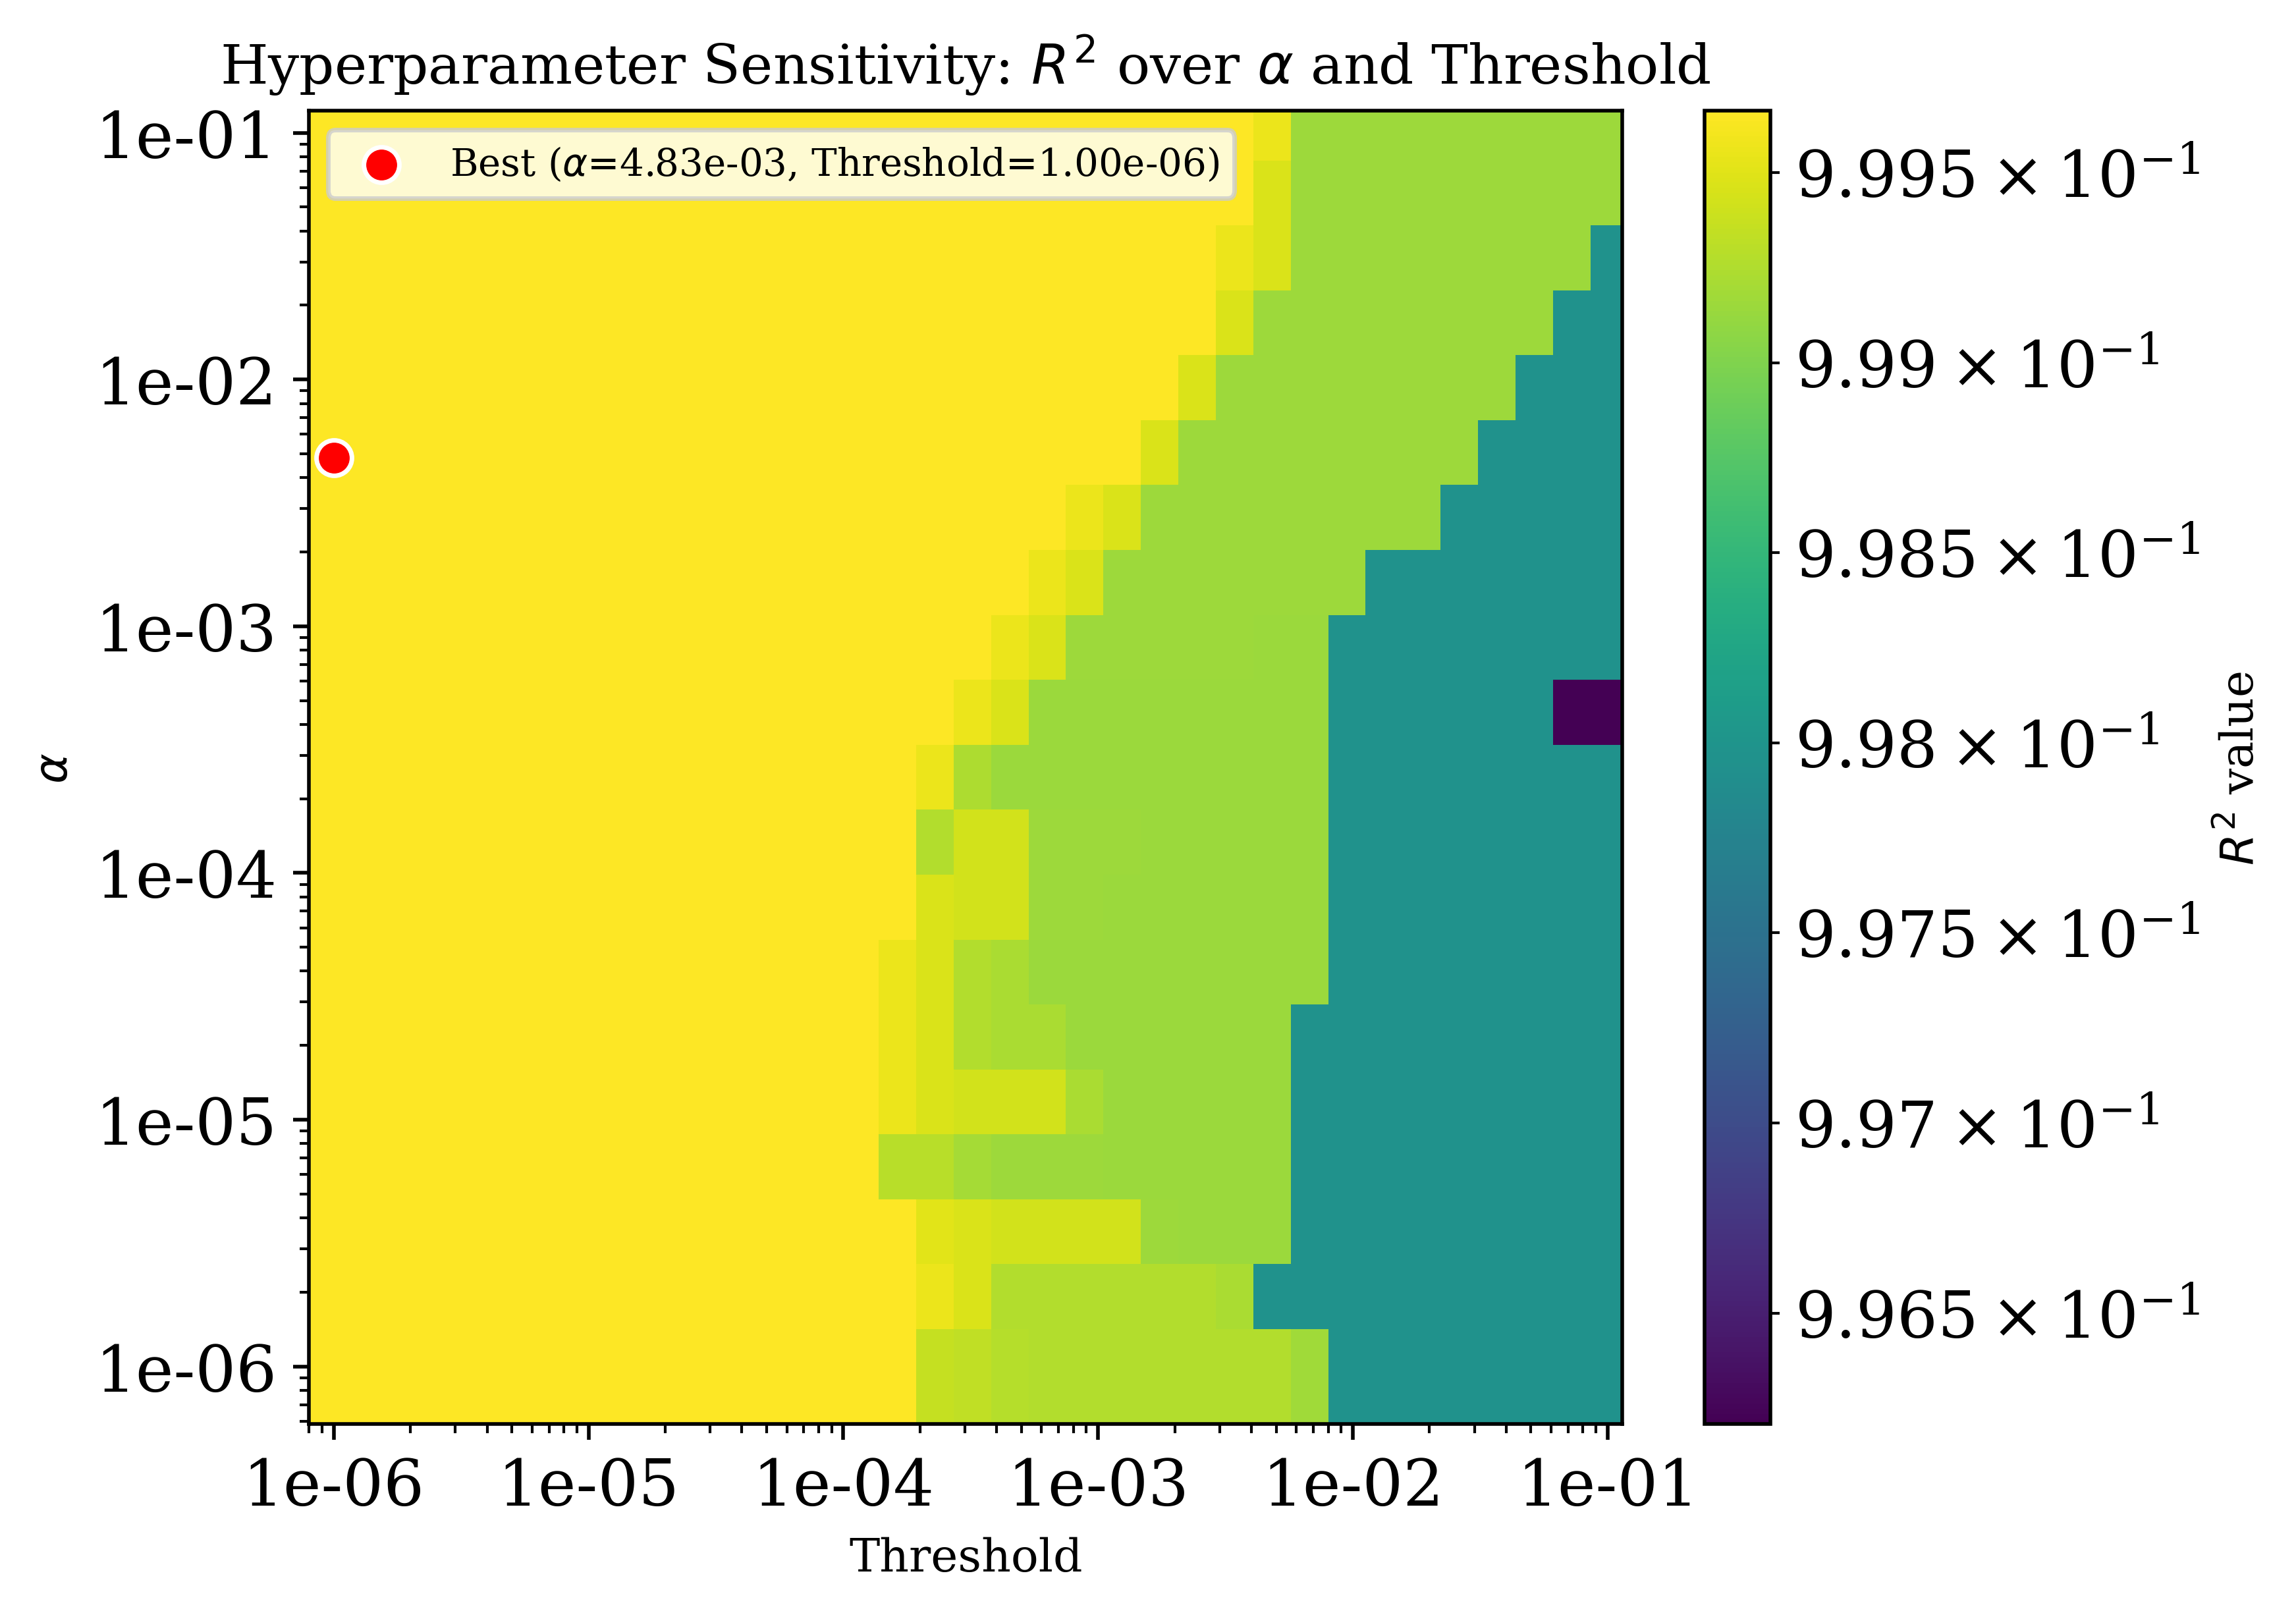

In [19]:
#####################################################
# Plot the Heatmap of R Square Scores from Grid Search
#####################################################

# Create the figure 
plt.figure(figsize=(7, 5), dpi=500)
plt.clf()

# Generate the meshgrid from alpha and threshold values
X, Y = np.meshgrid(thresholds, alphas)

# Plot the heatmap
mesh = plt.pcolormesh(
    X, Y, scores,
    norm=colors.LogNorm(vmin=scores.min(), vmax=scores.max()),
    cmap='viridis',
    shading='auto'
)

# Add colorbar
cbar = plt.colorbar(mesh, format=LogFormatterMathtext())
cbar.set_label("$R^2$ value", fontsize='medium')
cbar.ax.tick_params(labelsize='small')

# Set log-log axis
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))

# Plot the best point once
plt.scatter(
    best_params["threshold"], best_params["alpha"],
    color='red', s=60, edgecolor='white', zorder=10,
    label=fr'Best ($\alpha$={best_params["alpha"]:.2e}, Threshold={best_params["threshold"]:.2e})'
)

# Add labels and legend
plt.xlabel("Threshold", fontsize='medium')
plt.ylabel(r"$\alpha$", fontsize='medium')
plt.title("Hyperparameter Sensitivity: $R^2$ over $\\alpha$ and Threshold", fontsize='large')
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.tight_layout()
plt.savefig("Plots 4/heatmap_r2_ETIN.pdf", bbox_inches="tight")
plt.show()


In [26]:
#  Print the learned equations
print("The equations learned using SINDy:")
best_model.print(lhs=[f'd{var}/dt' for var in symbolic_names])


The equations learned using SINDy:
dx/dt = 1.000 1 + -1.000 x + -0.168 xy + 3.021 xy/(1 + y) + 0.050 z + -0.559 zy/(1 + y) + -0.001 u + 0.002 uy/(1+y)
dy/dt = 0.001 1 + -0.843 xy + 4.368 y + -0.176 y^2 + -0.151 z + 1.543 zy/(1 + y)
dz/dt = 0.045 1 + -0.002 xy + 0.003 xy/(1 + y) + 0.016 y + -0.001 y^2 + 24.601 z + -852.652 zy/(1 + y) + -0.032 u + 0.089 uy/(1+y)
du/dt = 1.000 1 + 0.002 z + -0.068 zy/(1 + y) + -0.666 u


In [27]:
# Simulate forward in time
ICs = x_train[0]  
x_train_simulated = best_model.simulate(ICs, t_train)
dt_forward = t_train[1] - t_train[0]
tf = t_train[-1]
forward_time = np.arange(0, tf + 50, dt_forward)
simulated_forward = best_model.simulate(ICs, forward_time)


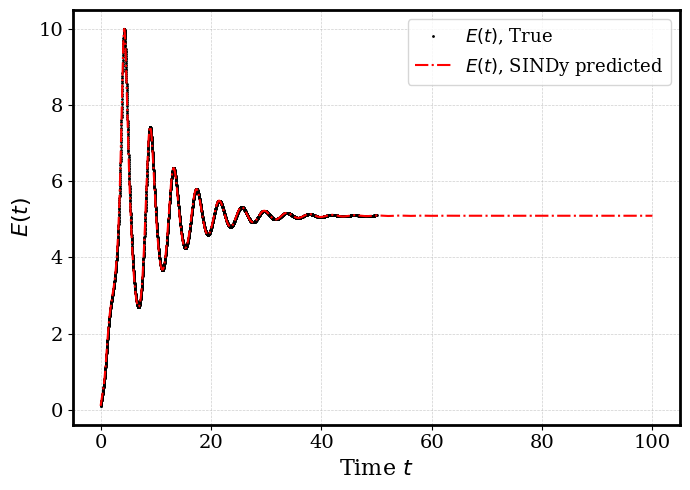

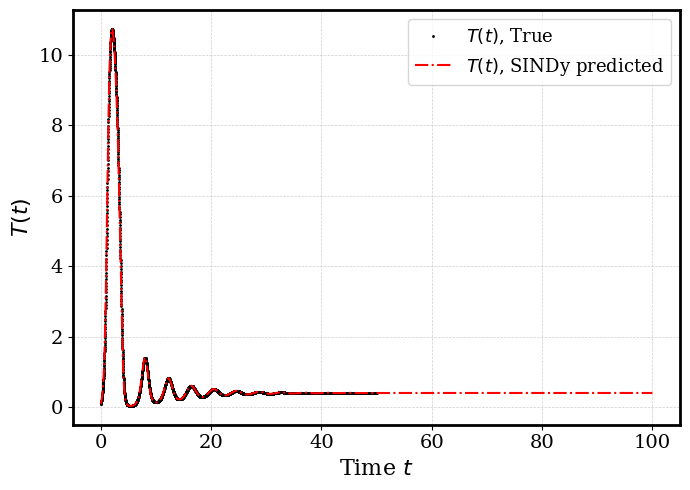

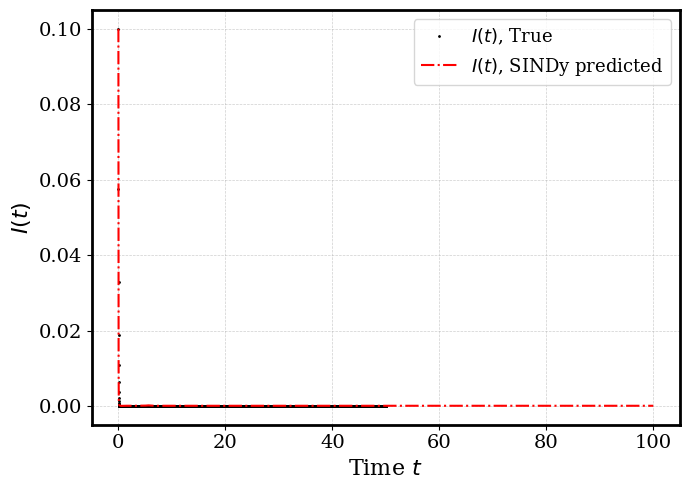

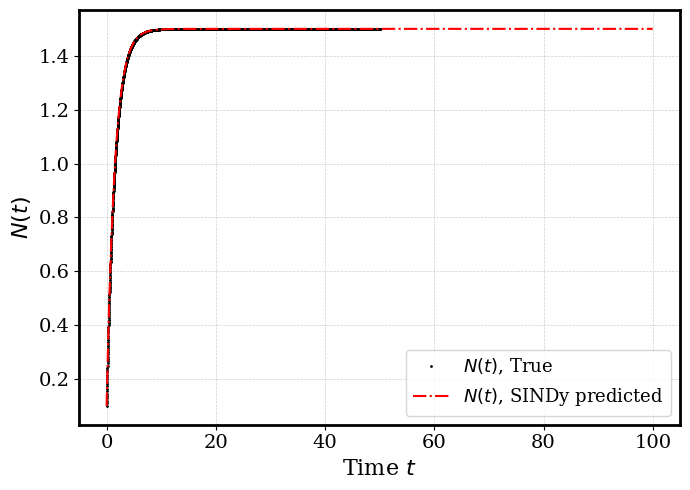

In [28]:
## Plot the original and simulated time series for all variables
for i, var in enumerate(user_vars):
    fig, ax = plt.subplots(figsize=(7, 5), dpi=100)

    # True signal
    ax.plot(t_train, x_train[:, i], 'k.', label=f'${var}(t)$, True', markersize=2)

    # Simulated signal
    ax.plot(forward_time, simulated_forward[:, i], 'r-.',
            label=f'${var}(t)$, SINDy predicted', linewidth=1.5)

    ax.set(xlabel='Time $t$', ylabel=f'${var}(t)$')
    ax.grid(True, which='both', ls='--', lw=0.5)
    ax.legend()
    set_spines_black(ax)
    fig.tight_layout()
    filename = f"Plots 4/{var}_time_series.pdf"
    plt.savefig(filename, bbox_inches="tight")
    plt.show()


In [29]:
# ------------------------------------------------------------------
# Extract feature names and coefficients from the model
# ------------------------------------------------------------------
library_name = best_model.get_feature_names()
coeffs = np.round(best_model.coefficients(), 3)
eq_labels = [f'd{v}/dt' for v in symbolic_names]

sindy_results = pd.DataFrame(coeffs, index=eq_labels, columns=library_name)
print(" SINDy Coefficient Matrix:")
display(sindy_results)

 SINDy Coefficient Matrix:


,1,x,xy,xy/(1 + y),y,y^2,z,zy/(1 + y),u,uy/(1+y)
dx/dt,1.000,-1.0,-0.168,3.021,-0.000,0.000,0.050,-0.559,-0.001,0.002
dy/dt,0.001,-0.0,-0.843,0.000,4.368,-0.176,-0.151,1.543,-0.000,-0.000
dz/dt,0.045,-0.0,-0.002,0.003,0.016,-0.001,24.601,-852.652,-0.032,0.089
du/dt,1.000,0.0,-0.000,0.000,0.000,-0.000,0.002,-0.068,-0.666,-0.000


In [30]:
# ------------------------------------------------------------------
# Build symbolic RHS expressions
# ------------------------------------------------------------------
var_syms = symbols(symbolic_names) 
rhs_exprs = [build_symbolic_rhs(coeffs[i], library_name) for i in range(len(symbolic_names))]

print("\n Symbolic RHS Expressions:")
for lhs, rhs in zip(eq_labels, rhs_exprs):
    print(f"{lhs} = {rhs}")


 Symbolic RHS Expressions:
dx/dt = 0.002*u*y/(y + 1) - 0.001*u - 0.168*x*y + 3.021*x*y/(y + 1) - 1.0*x - 0.559*y*z/(y + 1) + 0.05*z + 1.0
dy/dt = -0.843*x*y - 0.176*y**2 + 1.543*y*z/(y + 1) + 4.368*y - 0.151*z + 0.001
dz/dt = 0.089*u*y/(y + 1) - 0.032*u - 0.002*x*y + 0.003*x*y/(y + 1) - 0.001*y**2 - 852.652*y*z/(y + 1) + 0.016*y + 24.601*z + 0.045
du/dt = -0.666*u - 0.068*y*z/(y + 1) + 0.002*z + 1.0


In [31]:
# ------------------------------------------------------------------
#  Lambdify for numerical use
# ------------------------------------------------------------------
f_numeric = lambdify(var_syms, rhs_exprs, modules="numpy")

def sindy_func(values):
    return f_numeric(*values)

In [32]:
# ------------------------------------------------------------------
# Find steady states
# ------------------------------------------------------------------
domain = [(0, None)] * len(symbolic_names)
sindy_ss = find_steady_states(
    sindy_func,
    num_vars=len(symbolic_names),
    num_samples=10000,
    tol=1e-8,
    domain=domain,
    seed = 42
)
print("\n Steady States Found:")
for i, ss in enumerate(sindy_ss, 1):
    coord_str = ', '.join(f"{N(v, 4)}" for v in ss)
    print(f"  Steady state {i}: ({coord_str})")


 Steady States Found:
  Steady state 1: (1.124, 0.02971, 0.9625, 1.502)
  Steady state 2: (5.100, 0.4059, 0.0001902, 1.501)


In [33]:
# ------------------------------------------------------------------
#  Compute symbolic Jacobian
# ------------------------------------------------------------------
vars_matrix = Matrix(var_syms)
rhs_matrix = Matrix(rhs_exprs)
J = rhs_matrix.jacobian(vars_matrix).applyfunc(lambda e: e.evalf(4))

# print("\n Symbolic Jacobian Matrix:")
# display(J)

# ------------------------------------------------------------------
#  Evaluate Jacobian and eigenvalues at each steady state
# ------------------------------------------------------------------
J_at_ss = []
for i, ss_point in enumerate(sindy_ss, 1):
    subs_dict = dict(zip(var_syms, ss_point))
    J_eval = J.subs(subs_dict).evalf(4)
    J_at_ss.append(J_eval)

    coord_str = ', '.join(f"{N(val, 3)}" for val in ss_point)
    print(f"\nJacobian at SS {i} = ({coord_str}):")
    sp.pprint(J_eval)

    eigs = J_eval.eigenvals()
    print(f"Eigenvalues at SS {i}:")
    for ev, mult in eigs.items():
        print(f"  {ev.evalf(4)}  (×{mult})")


Jacobian at SS 1 = (1.12, 0.0297, 0.963, 1.50):
⎡-0.9178    2.508     0.03387   -0.0009423⎤
⎢                                         ⎥
⎢-0.02505   4.811     -0.1065       0     ⎥
⎢                                         ⎥
⎢2.714e-5   -773.8   -0.001185   -0.02943 ⎥
⎢                                         ⎥
⎣   0      -0.06173  3.794e-5     -0.666  ⎦
Eigenvalues at SS 1:
  11.8 - 4.235e-22*I  (×1)
  -6.976 - 2.604e-21*I  (×1)
  -0.9271 - 4.735e-23*I  (×1)
  -0.6660  (×1)

Jacobian at SS 2 = (5.10, 0.406, 0.000190, 1.50):
⎡ -0.196     6.939    -0.1114   -0.0004225⎤
⎢                                         ⎥
⎢-0.3422   -0.07393    0.2945       0     ⎥
⎢                                         ⎥
⎢5.432e-5  -0.001706   -221.6   -0.006304 ⎥
⎢                                         ⎥
⎣   0      -6.543e-6  -0.01763    -0.666  ⎦
Eigenvalues at SS 2:
  -221.6 + 9.629e-21*I  (×1)
  -0.1349 - 1.54*I  (×1)
  -0.1349 + 1.54*I  (×1)
  -0.6660  (×1)



Interaction network near SS 1 = (1.12, 0.0297, 0.963, 1.50):


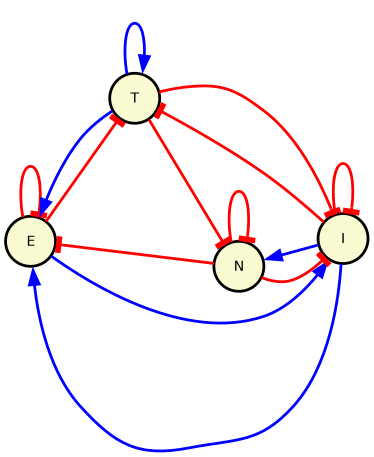


Interaction network near SS 2 = (5.10, 0.406, 0.000190, 1.50):


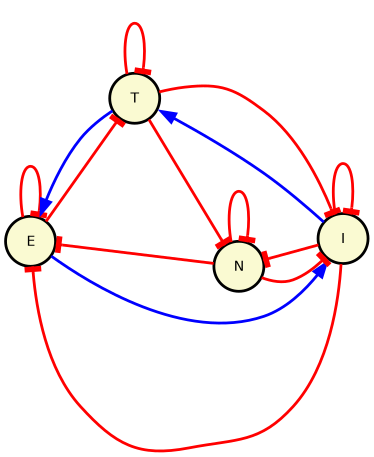

In [34]:
# ----------------------------------
#  Visualize interaction networks 
# ----------------------------------
try:
    Jacobians_np = [np.array(J_ss.tolist(), dtype=float) for J_ss in J_at_ss]
    for i, (J_np, ss_point) in enumerate(zip(Jacobians_np, sindy_ss), 1):
        output_path = f"Plots 4/ETIN_network{i}"
        graph = draw_network(
            J_np,
            nodes=user_vars,
            output_path=output_path,
            label_fontsize=10,
            graph_size='10,10',
            dpi=100
        )

        coord_str = ', '.join(f"{N(v, 3)}" for v in ss_point)
        print(f"\nInteraction network near SS {i} = ({coord_str}):")
        display(Image(filename=output_path + '.png'))

except Exception as e:
    print(f" Can't  Draw the Network: {e}")

In [25]:
###########################################################################################################################################